***
***

<h2><center><font color='blue'>Cours n°2</font></center> </h2>

<h2><center>Pré-traitements de corpus et représentations numériques de textes</center> </h2>

***
***

***
# <font color='blue'> 1. Pré-traitements </font>
***

In [ ]:
# Importation de textes pour les exemples

import pandas as pd
import io
import glob

liste_dossiers = glob.glob("C:/Users/thoma/Documents/CHU Toulouse/anonyme/*.txt")
liste_dossiers

In [ ]:
med_dos = []
for dossier in liste_dossiers:
    with io.open(dossier, 'r', encoding='utf8') as f:
        text = f.read()
        med_dos.append(text)

med_dos = pd.DataFrame(med_dos)
med_dos.columns = ['dossier']
med_dos

In [ ]:
med_dos['dossier'].loc[0]

In [ ]:
print(med_dos['dossier'].loc[0])

## 1.1. Nettoyage et uniformisation

Etapes classiques de nettoyage de textes : <br>

* mise en minuscule du texte
* suppression de la ponctuation
* suppression des chiffres
* suppression des espaces sur-numéraires
* passage en unicode
* enlever les lettres seules

In [ ]:
from gensim import utils
import gensim.parsing.preprocessing as gsp
import unidecode

filters = [ 
           gsp.strip_punctuation,
           gsp.strip_numeric, 
           gsp.strip_multiple_whitespaces,
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    # s = unidecode.unidecode(s)
    for f in filters:
        s = f(s).strip()
    s = ' '.join( [w for w in s.split() if len(w)>1] )
    return s

med_dos['dossier_clean'] = med_dos['dossier'].apply(lambda x : clean_text(x))

In [ ]:
med_dos['dossier_clean'].loc[0]

***

## 1.2. "Stop-words"

Dans certaines approches, certains mots peuvent n'avoir aucune "valeur" et introduire du biais par leur trop grande fréquance dans le corpus (loi de Zipf), il peut donc être intéressant de les supprimer

In [ ]:
import spacy
from spacy.lang.fr import French

nlp = French()

print(sorted(nlp.Defaults.stop_words))

In [ ]:
# Ajouter un stop-words
nlp.Defaults.stop_words.add("chaton")

# Ajouter des stop-words
nlp.Defaults.stop_words |= {"chat","chien",}

# Supprimer un stop-words
nlp.Defaults.stop_words.remove("été")

# Supprimer des stop-words
nlp.Defaults.stop_words -= {"être", "ô"}

In [ ]:
print(sorted(nlp.Defaults.stop_words))

In [ ]:
import numpy as np

med_dos['dossier_clean_stopword'] = np.nan

for num in list(med_dos.index):
    text = med_dos.dossier_clean.loc[num]
    doc = nlp(text)
    filtered_sent=[]
    for word in doc:
        if word.is_stop==False:
            filtered_sent.append(word)
    clean_sent = ' '.join(str(v) for v in filtered_sent)
    med_dos.loc[num, 'dossier_clean_stopword'] = clean_sent

In [ ]:
med_dos

In [ ]:
med_dos['dossier_clean_stopword'].loc[0]

***

## 1.3. Stemming & Lemmatization

Le but de la radicalisation (stemming) et de la lemmatisation est de réduire les formes flexionnelles et parfois les formes dérivées d'un mot à une forme de base commune.

- Radicalisation

In [ ]:
from nltk.stem.snowball import FrenchStemmer

stemmer = FrenchStemmer()

for item in ["Biologie", "Biologique", "Biologiquement"]:
    print(item, ' >>> ', stemmer.stem(item))


In [ ]:
for item in ["changer", "changera", "changaient"]:
    print(item, ' >>> ', stemmer.stem(item))

In [ ]:
med_dos['dossier_clean_stopword_stemm'] = np.nan

for num in list(med_dos.index):
    text = med_dos.dossier_clean_stopword.loc[num]
    doc = nlp(text)
    filtered_sent=[]
    for word in doc:
        filtered_sent.append(stemmer.stem(str(word)))
    clean_sent = ' '.join(str(v) for v in filtered_sent)
    med_dos.loc[num, 'dossier_clean_stopword_stemm'] = clean_sent

In [ ]:
med_dos

In [ ]:
med_dos['dossier_clean_stopword_stemm'].loc[0]

- Lemmatisation

In [ ]:
import spacy

nlp = spacy.load('fr_core_news_md')
doc = nlp(u"changer changera changeaient")

for token in doc:
    print(token , ' >>> ' , token.lemma_)

In [ ]:
import spacy

nlp = spacy.load('fr_core_news_md')
doc = nlp(u"Le fond des yeux présentait une structure granuleuse")

filtered_sent=[]
for word in doc:
    filtered_sent.append(word.lemma_)
clean_sent = ' '.join(str(v) for v in filtered_sent)

print(clean_sent)

In [ ]:
med_dos['dossier_clean_stopword_lemm'] = np.nan

for num in list(med_dos.index):
    text = med_dos.dossier_clean_stopword.loc[num]
    doc = nlp(text)
    filtered_sent=[]
    for word in doc:
        filtered_sent.append(word.lemma_)
    clean_sent = ' '.join(str(v) for v in filtered_sent)
    med_dos.loc[num, 'dossier_clean_stopword_lemm'] = clean_sent

In [ ]:
med_dos

In [ ]:
med_dos['dossier_clean_stopword_lemm'].loc[0]

## 1.4. Segmentation & Tokenisation

<b>Définition</b> : La segmentation de texte est le processus de fractionnement de texte en unités d'intérêt

Deux niveaux de segmentation (généralement) requis:

- Diviser le texte brut en unités de modélisation (ex : phrase, paragraphe, sections, chapitres,...)
<br>

- Divisez les unités de modélisation en une séquence d'unités de base, appelées « <b>tokens</b> » (par exemple: mots, morceaux de mots, caractères,...)
<br>

La <b>tokenisation</b> est un terme large (vague) qui fait simplement référence au processus de diviser le texte brut en séquences de tokens (segmentation de mots, à la segmentation des mots, fractionnement des caractères...).
<br>

NB: Dans son sens le plus courant, la tokenisation fait référence à la segmentation de mots.

In [ ]:
# Segmentation par paragraphe
med_dos['dossier'].loc[0].split('\n')

In [ ]:
# Segmentation par mots
from nltk.tokenize import word_tokenize
text_tokens = [[text for text in word_tokenize(doc)] for doc in med_dos['dossier_clean_stopword_lemm']]
text_tokens

In [ ]:
# Segmentation par mots
from nltk.tokenize import word_tokenize
text_tokens = [[text for text in word_tokenize(doc)] for doc in med_dos['dossier_clean_stopword_stemm']]
text_tokens

***
# <font color='blue'> 2. Représentation numérique de données textuelles </font>
***

Il faut représenter les données textuelles sous forme numérique. 
En effet, Pour appliquer des algorithmes d’IA sur des données textuelles, il est nécessaire de transformer le texte en nombres, seul « input » compréhensible par les algorithmes de Machine/Deep Learning. 

Pour la suite :
    
- Un mot est l’unité de base (Token) des données discrètes, définie comme un élément d'un vocabulaire V indexé de 1 à n.
<br>

- Un document est une suite de N mots désignés par: d = (m1, m2, ..., mN), où mN est le n-ième mot de la séquence
<br>

- Un corpus est une collection de documents C notée par : C = d1, d2, ..., dM
<br>

Étant donné un vocabulaire V et un corpus D, notre objectif est d'associer chaque mot avec une structure de données numérique afin de pouvoir :

- identifier chaque mot
<br>

- capturer les similitudes des mots (en fonction de la morphologie, de la syntaxe, de la sémantique,...)

On parle de <b>Word Embeddings / Word Vectorization</b>


***

## 2.1. Approche "1-hot encoding"

L'encodage "one-hot" ou "encodage 1 parmi n" est une représentation de variables catégorielles sous forme de vecteurs binaires.

Cela nécessite d'abord que les valeurs catégorielles soient mappées sur des valeurs entières.

Ensuite, chaque valeur entière est représentée sous la forme d'un vecteur binaire qui contient toutes des valeurs nulles, à l'exception de l'indice de l'entier, qui est marqué d'un 1.

Exemple : 

- C = {"Chat" : 1, "Chien" : 2, "Pomme" : 3, "Poire" : 4, "Voiture" : 5}

- C_1-hot_encoding  = {"Chat"    : [10000], "Chien"   : [01000], "Pomme"   : [00100], "Poire"   : [00010], "Voiture" : [00001]}

In [ ]:
import numpy as np
docs = "la cellule Eucaryote possède un noyau".lower().split()
doc1 = set(docs)
doc1 = sorted(doc1)
print ("\nvalues: ", doc1)

integer_encoded = []
for i in docs:
    v = np.where( np.array(doc1) == i)[0][0]
    integer_encoded.append(v)
print ("\ninteger encoded: ",integer_encoded)

def get_vec(len_doc,word):
    empty_vector = [0] * len_doc
    vect = 0
    find = np.where( np.array(doc1) == word)[0][0]
    empty_vector[find] = 1
    return empty_vector

def get_matrix(doc1):
    mat = []
    len_doc = len(doc1)
    for i in docs:
        vec = get_vec(len_doc,i)
        mat.append(vec)
        
    return np.asarray(mat)

print ("\nMATRIX:")
print (get_matrix(doc1))

In [ ]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

doc1 = "la cellule procaryote ne possède pas de noyau".lower().split()
doc2 = "la cellule Eucaryote possède un noyau".lower().split()
doc1_array = array(doc1)
doc2_array = array(doc2)
doc3 = doc1+doc2
doc3 = set(doc3)
data = list(doc3)

values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

# invert first example
# inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
# print(inverted)

Cette approche possède 2 limites majeures :
<br>

- Elle n'est pas très informative car il considère tous les mots également équidistants (eucaryote et procarypte sont considérées comme des entitées totalement différentes !)

                ||Procaryote - Eucaryote|| = ||Eucaryote - possèder|| = ||Procaryote - pas||

- Elle ne retranscrit pas la Polysémie : la souris d'un ordinateur obtient le même vecteur que la souris (animal)



***

## 2.2. Approche "Count Vector" aka "Bag-of-Words / Bag-Of-Ngram"

Dans cette approche, un document est représenté par un vecteur de la même taille que le vocabulaire, dont la composante i indique le nombre d'occurrences du ième mot du vocabulaire dans le document. Le vocabulaire est construit à partir de l’ensemble des mots et des n-gram (combinaisons de n mots qui se suivent, en général 2 ou 3) du corpus de documents. La constitution du vocabulaire est ainsi une étape critique pour les performances des systèmes utilisant une telle représentation.

Reprenons le Corpus de documents C = {d1, d2, ..., dM} qui contient N tokens (mots) uniques d'un dictionnaire. 

On construit une matrice M en 2D :
- le nombre de documents de C représente l'axe Y 
- Le nombre de tokens uniques N représente l'axe X 

Chaque ligne de la matrice M contient le nombre des tokens dans le document d(i) et la somme de chaque colonne donne le nombre d'occurence du token dans le Corpus 

Exemple :

doc1 = "la cellule Procaryote ne possède pas de noyau"
<br>
doc2 = "la cellule Eucaryote possède un noyau"

C = {doc1, doc2}

N = {"la", "cellule", "Procaryote", "Eucaryote", "ne", "possède", "pas", "un", "de", "noyau"}

Ici, C = 2, N = 10




In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ["la cellule Procaryote ne possède pas de noyau",
          "la cellule Eucaryote possède un noyau"]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names())

In [ ]:
print(X.toarray())

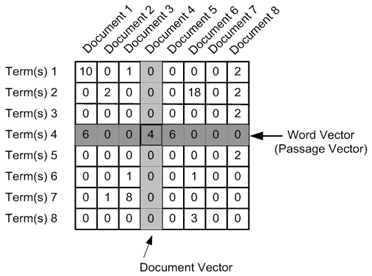

On peut également faire des "N-grams":

In [ ]:
# Bi-grams
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names())
print(X2.toarray())

In [ ]:
# Tri-grams
vectorizer3 = CountVectorizer(analyzer='word', ngram_range=(3, 3))
X3 = vectorizer3.fit_transform(corpus)
print(vectorizer3.get_feature_names())
print(X3.toarray())

Cette approche possède 2 limites majeures :
<br>

- La matrice peut rapidement devenir très TRES grande selon la taille du corpus et la longueur des documents surtout en augmentant la taille des n-grams pour "capter" la strucutre grammaticale
<br>

- ne permet pas de représenter la fréquence des mots / n-grams (= importance relative)


***

## 2.3. Approche "TF-IDF" 

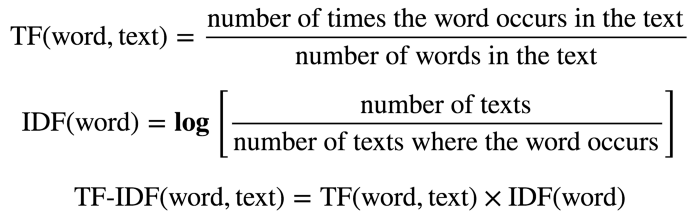

Il s’agit d’une méthode de pondération du modèle vectoriel Bag-of-Words qui permet de mesurer l'importance d'un terme contenu dans un document relativement à une collection ou un corpus de documents. Le poids du terme augmente proportionnellement au nombre d'occurrences du mot dans le document et diminue en fonction du nombre d'occurrences du mot dans le corpus.

Les mots courants tels que «est», «le», «un», etc. ont tendance à apparaître assez fréquemment par rapport aux mots qui sont importants pour un document (Loi de Zipf). Par exemple, un document A qui parle de biologie cellulaire va contenir plus d'occurrences du mot « Cellule » par rapport à d'autres documents. Mais des mots courants comme «le», etc. seront également présents à une fréquence plus élevée dans presque tous les documents.

TF-IDF permet de réduire le poids des mots courants présents dans presque tous les documents d'un corpus et donner plus d'importance aux mots qui apparaissent dans un sous-ensemble de documents.

TF-IDF fonctionne en pénalisant ces mots communs en leur attribuant des poids plus faibles tout en donnant de l'importance à des mots comme « Cellule » dans un document particulier.

***
## Exemple :

T1 = "la cellule Procaryote ne possède pas de noyau et possède des mitochondries"

T2 = "la cellule Eucaryote possède un noyau et des mitochondries"

Ici,
- Vocabulaire : ‘la’, ‘cellule’, ‘Procaryote’, ‘Eucaryote’, ‘ne’, ‘possède’, ‘un’, ‘pas’, ‘de’,  ‘noyau’, ‘et’, ‘des’, ‘mitochondries’
- Taille du corpus = 2
- Taille du vocabulaire = 13
- Nombre de mots distincts dans T1 = 11
- Nombre de mots distincts dans T2 = 9

### Term Frequency (TF)

TF(mot, texte) = Nb. de fois où le mot apparait dans le texte / nombre de mots distincts dans le texte > Donc on calcule un TF par mot et par texte

Pour T1:

    TF(‘la’) = 1/11 = 0.09
    TF(‘cellule’) = 1/11 = 0.09
    TF(‘Procaryote’) = 1/11 = 0.09
    TF(‘Eucaryote’) = 0/11 = 0
    TF(‘ne’) = 1/11 = 0.09
    TF(‘possède’) = 2/11 = 0.18
    TF(‘un’) = 0/11 = 0
    TF(‘pas’) = 1/11 = 0.09
    TF(‘de’) = 1/11 = 0.09
    TF(‘noyau’) = 1/11 = 0.09
    TF(‘et’) = 1/11 = 0.09
    TF(‘des’) = 1/11 = 0
    TF(‘mitochondries’) = 1/11 = 0.09
    
Pour T2:

    TF(‘la’) = 1/9 = 0.11
    TF(‘cellule’) = 1/9 = 0.11
    TF(‘Procaryote’) = 0/9 = 0
    TF(‘Eucaryote’) = 1/9 = 0.11
    TF(‘ne’) = 0/9 = 0
    TF(‘possède’) = 1/9 = 0.11
    TF(‘un’) = 1/9 = 0.11
    TF(‘pas’) = 0/9 = 0
    TF(‘de’) = 1/9 = 0.11
    TF(‘noyau’) = 1/ = 0.11
    TF(‘et’) = 1/9 = 0.11
    TF(‘des’) = 1/9 = 0.11
    TF(‘mitochondries’) = 1/9 = 0.11

### Inverse Document Frequency (IDF)

IDF(mot) = Log(Nb. de textes du corpus / nombre de textes ou le mot apparait) > Donc on calcule un TF par mot pour tout le corpus

Pour notre exemple:

    IDF(‘la’) = log(2/2) = 0
    IDF(‘cellule’) = log(2/2) = 0
    IDF(‘Procaryote’) = log(2/1) = 0.3
    IDF(‘Eucaryote’) = log(2/1) = 0.3
    IDF(‘ne’) = log(2/1) = 0.3
    IDF(‘possède’) = log(2/2) = 0
    IDF(‘un’) = log(2/1) = 0.3
    IDF(‘pas’) = log(2/1) = 0.3
    IDF(‘de’) = log(2/2) = 0
    IDF(‘noyau’) = log(2/2) = 0
    IDF(‘et’) = log(2/2) = 0
    IDF(‘des’) = log(2/2) = 0
    IDF(‘mitochondries’) = log(2/2) = 0

### TF-IDF

Pour T1:

    TF-IDF(‘la’) = 0.09 x 0 = 0
    TF-IDF(‘cellule’) = 0.09 x 0 = 0
    TF-IDF(‘Procaryote’) = 0.09 x 0.3 = 0.027
    TF-IDF(‘Eucaryote’) = 0 x 0.3 = 0
    TF-IDF(‘ne’) = 0.09 x 0.3 = 0.027
    TF-IDF(‘possède’) = 0.18 x 0 = 0
    TF-IDF(‘un’) = 0 x 0.3 = 0
    TF-IDF(‘pas’) = 0.09 x 0.3 = 0.027
    TF-IDF(‘de’) = 0.09 x 0 = 0
    TF-IDF(‘noyau’) = 0.09 x 0 = 0
    TF-IDF(‘et’) = 0.09 x 0 = 0
    TF-IDF(‘des’) = 0 x 0 = 0
    TF-IDF(‘mitochondries’) = 0.09 x 0 = 0
    
Pour T2:

    TF-IDF(‘la’) = 0.11 x 0 = 0
    TF-IDF(‘cellule’) = 0.11 x 0 = 0
    TF-IDF(‘Procaryote’) = 0 x 0.3 = 0
    TF-IDF(‘Eucaryote’) = 0.11 x 0.3 = 0.033
    TF-IDF(‘ne’) = 0 x 0.3 = 0
    TF-IDF(‘possède’) = 0.11 x 0 = 0
    TF-IDF(‘un’) = 0.11 x 0 = 0
    TF-IDF(‘pas’) = 0 x 0.3 = 0
    TF-IDF(‘de’) = 0.11 x 0 = 0
    TF-IDF(‘noyau’) = 0.11 x 0 = 0
    TF-IDF(‘et’) = 0.11 x 0 = 0
    TF-IDF(‘des’) = 0.11 x 0 = 0
    TF-IDF(‘mitochondries’) = 0.11 x 0 = 0


***

In [ ]:
corpus = ["la cellule Procaryote ne possède pas de noyau et possède des mitochondries",
          "la cellule Eucaryote possède un noyau et des mitochondries"]

from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
# cv = TfidfVectorizer(max_df=0.5, min_df=2)
tfidf_vectors = cv.fit_transform(corpus)

In [ ]:
cv.vocabulary_

{k: v for k, v in sorted(cv.vocabulary_.items(), key=lambda item: item[1])}

In [ ]:
tfidf_vectors.shape

In [ ]:
print(tfidf_vectors[0])

In [ ]:
print(tfidf_vectors[1])

***

In [ ]:
corpus = med_dos['dossier_clean_stopword_stemm']

from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
# cv = TfidfVectorizer(max_df=0.5, min_df=1)
tfidf_vectors = cv.fit_transform(corpus)

In [ ]:
cv.vocabulary_

In [ ]:
len(cv.vocabulary_)

In [ ]:
tfidf_vectors.shape

In [ ]:
print(tfidf_vectors[0])

Cette approche possède 2 limites majeures :
<br>

- ne tient pas compte de l’ordre des mots dans le document et surtout du sens sémantique des mots (utiliser des n-grams est un quick fix qui peut atteindre ses limites rapidement)

***

## 2.4. Approche "Fixed Word embedding"

Le word embedding est une méthode d'apprentissage d'une représentation vectorielle des mots. 

Cette technique permet de représenter chaque mot par un vecteur dense de nombres réels. 

Avec cette représentation, les mots apparaissant dans des contextes similaires possèdent des vecteurs correspondants qui sont relativement proches. Par exemple, les synonymes sont représentés par des vecteurs relativement peu distants dans l'espace vectoriel où sont définis ces vecteurs. 

Cette technique est basée sur l'hypothèse de Harris qui veut que les mots apparaissant dans des contextes similaires aient des significations apparentées. 

C’est un algorithme qui va apprendre cette représentation soit de manière non supervisée (ex : Word2vec, Glove) soit directement dans le réseau de neurones utilisé pour une tâche X d’apprentissage.

La technique des word embeddings diminue la dimension de la représentation des mots en comparaison d'un modèle Tf-Idf par exemple, facilitant ainsi les tâches d'apprentissage impliquant ces mots, puisque moins soumis au fléau de la dimension (curse of dimensionality en anglais).



***

### Word2Vec

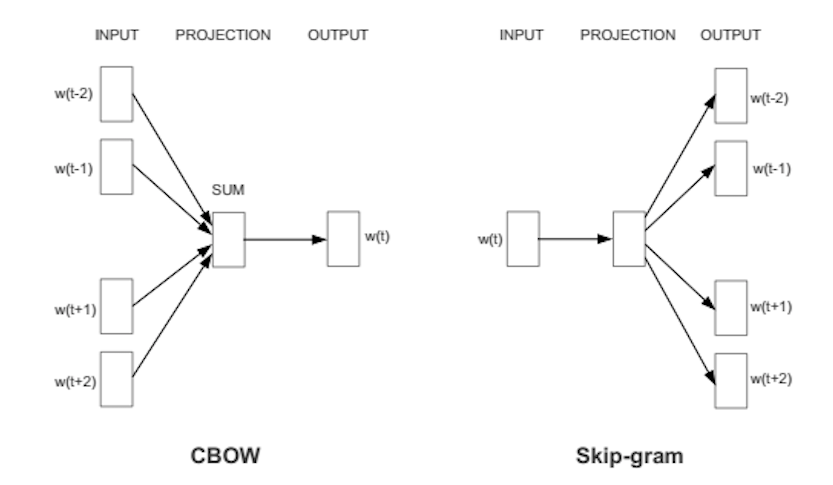

Cet algorithme de word embedding est parmi les plus connus. Il a été développé par une équipe de recherche de Google sous la direction de Tomas Mikolov. Il repose sur des réseaux de neurones à deux couches et cherche à apprendre les représentations vectorielles des mots composant un texte, de telle sorte que les mots qui partagent des contextes similaires soient représentés par des vecteurs numériques proches.

Word2Vec possède deux architectures neuronales, appelées CBOW et Skip-Gram, parmis lesquelles l’utilisateur peut choisir:

- CBOW (Continuous Bag-of-WORD) reçoit en entrée le contexte d’un mot, c’est à dire les termes qui l’entourent dans une phrase, et essaye de prédire le mot en question. 


- Skip-Gram fait exactement le contraire : elle prend en entrée un mot et essaye de prédire son contexte.

Dans les deux cas, l’entraînement du réseau se fait en parcourant le texte fourni et en modifiant les poids neuronaux afin de réduire l’erreur de prédiction de l’algorithme.

Word2Vec possède différents paramètres, dont les plus importants sont :

- La dimensionnalité de l’espace vectoriel à construire, c’est à dire le nombre de descripteurs numériques utilisés pour décrire les mots (entre 100 et 1000 en général).

- La taille du contexte d’un mot, c’est à dire le nombre de termes entourant le mot en question (les auteurs suggèrent d’utiliser des contextes de taille 10 avec l’architecture Skip-Gram et 5 avec l’architecture CBOW).

Étant donné que Word2Vec n’est composé que de deux couches, cet algorithme est rapide à entraîner et à exécuter, ce qui se révèle être un avantage important par rapport à d’autre méthodes de word embedding.


***

In [ ]:
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

txt = list(med_dos['dossier_clean_stopword_lemm'])
df = pd.DataFrame({'texte': txt})

sent = [row.split() for row in df['texte']]

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

In [ ]:
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
w2v_model.build_vocab(sent, progress_per=10000)

In [ ]:
w2v_model.wv.vocab

In [ ]:
w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

In [ ]:
w2v_model.wv.most_similar(positive=["ganglion"])

***

### Doc2Vec

Doc2Vec est une adaptation de Word2Vec pour faire de l'embbeding de paragraphes / textes

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=200, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))


In [ ]:
%%capture

doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(txt).transform(txt)

In [ ]:
len(doc2vec_features)

In [ ]:
doc2vec_features[0]

### FastText

FastText est une bibliothèque de classification et de représentation de texte dévellopé par Facebook IA. Il transforme le texte en vecteurs continus qui peuvent être utilisés ultérieurement sur n'importe quelle tâche liée au NLP.

FastText distribue des vecteurs de mots pré-entraînés pour 157 langues, Entrainés sur du Crawl et Wikipedia. Ces modèles ont été entraînés en utilisant CBOW avec des poids de position, en dimension 300, avec des n-grams de longueur 5, une fenêtre de taille 5 et 10 négatifs.

Télécharger le modèle français : https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz

In [ ]:
import fasttext
import fasttext.util

ft = fasttext.load_model('C:/Users/thoma/Documents/NLP_ESME/Fasttext/cc.fr.300.bin')
ft.get_dimension()

ou

In [ ]:
import fasttext.util
import fasttext
fasttext.util.download_model('fr', if_exists='ignore')
ft = fasttext.load_model('cc.fr.300.bin')
ft.get_dimension()

In [ ]:
fasttext.util.reduce_model(ft, 100)
ft.get_dimension()

In [ ]:
ft.get_word_vector('cellule').shape

In [ ]:
ft.get_nearest_neighbors('procaryote')

In [ ]:
help(ft)

In [ ]:
corpus = ["la cellule Procaryote ne possède pas de noyau et possède des mitochondries",
          "la cellule Eucaryote possède un noyau et des mitochondries"]

vect = [ft.get_sentence_vector(text) for text in corpus]

In [ ]:
vect

In [ ]:
vect = [ft.get_sentence_vector(text) for text in med_dos.dossier_clean_stopword_lemm]

In [ ]:
vect

### Modèles BERT

Bidirectional Encoder Representations from Transformers

In [ ]:
import torch
camembert = torch.hub.load('pytorch/fairseq', 'camembert')
camembert.eval()  # disable dropout (or leave in train mode to finetune)

In [ ]:
masked_line = 'Le <mask> est trop mignon'
camembert.fill_mask(masked_line, topk=3)

In [ ]:
masked_line = "Le <mask> de la cellule contient l'ADN"
camembert.fill_mask(masked_line, topk=3)

## 2.5. Approche "Topic Modeling"

<b>Latent Semantic Analysis (LSA)</b> : À travers son formalisme vectoriel, le LSA permet d'établir des relations entre un ensemble de documents et les termes qu'ils contiennent. Il va construire des “concepts”, aussi appelés “topics”, liés aux documents et aux termes, de sorte qu’un document pourra être représenté par un vecteur de dimension finie dont chaque coordonnée sera associée à un concept (un “concept” étant une combinaison linéaire de mots apparaissant dans le même contexte).


<b>Latent Dirichlet Allocation (LDA)</b> : modèle probabiliste génératif qui permet de découvrir des structures thématiques cachées dans des vastes archives de documents, via des techniques d’inférence basées sur la statistique Bayésienne. Ce modèle produit le même type de représentation que LSA, seule la façon de construire les concepts est différente (probabiliste plutôt qu’algébrique).
